In [1]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 4/Timestep5_train_cat1.csv')
test_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 4/Timestep5_test_cat1.csv')
# holdout_data = pd.read_csv('')

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23845 entries, 0 to 23844
Data columns (total 70 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   id                                                               23845 non-null  int64  
 1   charttime                                                        23845 non-null  object 
 2   aniongap                                                         23845 non-null  int64  
 3   bicarbonate                                                      23845 non-null  float64
 4   bun                                                              23845 non-null  int64  
 5   calcium                                                          23845 non-null  float64
 6   chloride                                                         23845 non-null  int64  
 7   creatinine                              

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences_fixed(data, timestep):
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    columns_to_scale = [col for col in numeric_columns if col not in ['id', 'charttime', 'los_icu', 'icu_death', 'hour', 'icu_cat']]

    grouped_data = data.groupby('id')
    scaler = MinMaxScaler()

    time_series = []
    targets = []

    for _, group_data in grouped_data:
        scaled_data = scaler.fit_transform(group_data[columns_to_scale])

        target_data = group_data['los_icu'].iloc[-1]  # Adjust this if necessary

        time_series.append(scaled_data)
        targets.append(target_data)
    return np.array(time_series), np.array(targets)

In [4]:
timestep=5
train_sequences, train_targets = create_sequences_fixed(train_data, timestep)
test_sequences, test_targets = create_sequences_fixed(test_data, timestep)
# holdout_sequences, holdout_targets = create_sequences_fixed(holdout_data, timestep)

In [5]:
train_sequences.shape, train_targets.shape

((4769, 5, 59), (4769,))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(timestep, train_sequences.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             3808      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [7]:
print(model.layers[0].input_shape)

(None, 5, 59)


In [8]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_split=0.2)

Epoch 1/10
120/120 [==============================] - 2s 6ms/step - loss: 2.4563 - mae: 1.1553 - val_loss: 0.7165 - val_mae: 0.6969
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 0.5796 - mae: 0.6347 - val_loss: 0.5237 - val_mae: 0.5981
Epoch 3/10
120/120 [==============================] - 0s 4ms/step - loss: 0.5379 - mae: 0.6166 - val_loss: 0.5208 - val_mae: 0.5926
Epoch 4/10
120/120 [==============================] - 0s 4ms/step - loss: 0.5225 - mae: 0.6111 - val_loss: 0.5056 - val_mae: 0.6028
Epoch 5/10
120/120 [==============================] - 0s 4ms/step - loss: 0.5055 - mae: 0.6002 - val_loss: 0.5599 - val_mae: 0.6428
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 0.4948 - mae: 0.5982 - val_loss: 0.5017 - val_mae: 0.5920
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 0.4911 - mae: 0.5938 - val_loss: 0.5149 - val_mae: 0.6080
Epoch 8/10
120/120 [==============================] - 0s 3ms/step - loss: 0.

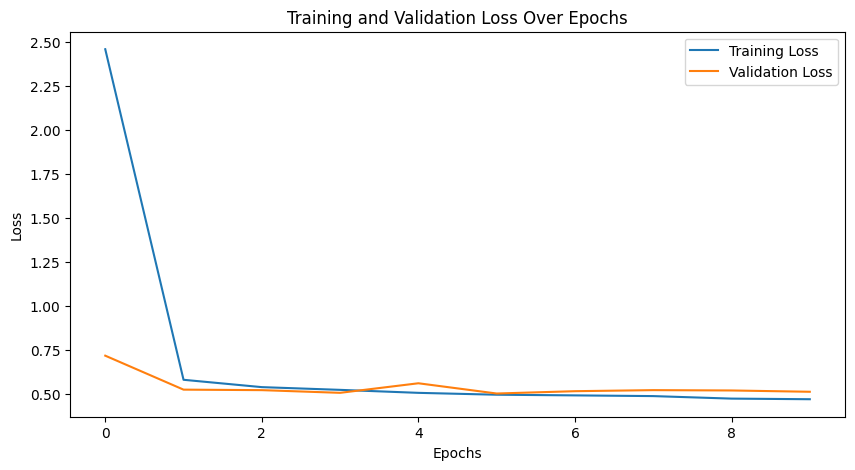

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.evaluate(test_sequences, test_targets)

38/38 [==============================] - 0s 4ms/step - loss: 0.5146 - mae: 0.6126


[0.5146388411521912, 0.6126208901405334]

In [11]:
test_predict = model.predict(test_sequences)
test_predict = np.round(test_predict, 2)

38/38 [==============================] - 0s 2ms/step


In [12]:
test_predict

array([[3.41],
       [3.41],
       [3.72],
       ...,
       [3.4 ],
       [3.51],
       [3.46]], dtype=float32)

In [13]:
test_targets

array([2.86, 2.85, 3.12, ..., 4.63, 2.73, 2.9 ])